# Generate input files for MOM6
Required components
* Horizontal grid
    + determined externally using FRE-NCtools, loaded here to provide geometry
* Vertical grid
    + either calculated here, or externally
* Sponge region
    + calculated here
* Intial conditions for tracers
    + T, S and biogeochemical tracers, calculated here
* Wind and buoyancy forcing
    + calculated here
* Topography
    + calculated here
* Inital velocity perturbation
    + used to nudge the model
    + calculated here


In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import initialization_functions as infs

In [26]:
# Load the grid
gridpath = '/work/gam/MOM6/inputs/channel/ocean_geometry.nc'
hgrid = xr.open_dataset(gridpath)
hgrid_ones = xr.ones_like(hgrid['geolon'])

In [27]:
X,Y = infs.calc_XYmeters(hgrid)

In [28]:
# Vertical grid
nk = 50
max_depth = 4000
min_depth = 0
thkcello_topcell = 1
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,thkcello_topcell=thkcello_topcell,method=method)

In [30]:
# Sponge region
idamp = infs.def_sponge_dampingtimescale_north(hgrid,sponge_width=[4,2],idampval=[1/(720*86400),1/(360*86400)])
eta = infs.def_sponge_interfaceheight(vgrid,hgrid)

In [43]:
# Temperature and salinity initial conditions
Tn = 10
Ts = 0
Sn = 35
Ss = 33

SST = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Tn, val_at_mincoord = Ts)
SSS = infs.calc_distribution(coordinate = Y, function='linear', val_at_maxcoord = Sn, val_at_mincoord = Ss)

NameError: name 'val_at_maxcoord' is not defined

In [ ]:
Sprofile = infs.calc_distribution(coordinate= -vgrid.zt, val_at_maxcoord)

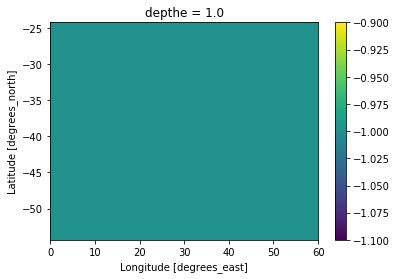

In [20]:
calc_init_SST(hgrid,Tn,Ts,function='linear')
calc_init_Tprofile(vgrid,SST,function='exponential',efolding=800)
calc_init_SSS(hgrid,Tn,Ts,function='linear')
calc_init_Sprofile(vgrid,SSS,function='')

In [46]:
vgrid['zw']

<xarray.DataArray 'zw' (NKp1: 51)>
array([0.000000e+00, 1.000000e+00, 4.347371e+00, 1.026988e+01, 1.889964e+01,
       3.033309e+01, 4.464699e+01, 6.190547e+01, 8.216375e+01, 1.054705e+02,
       1.318692e+02, 1.613994e+02, 1.940971e+02, 2.299956e+02, 2.691261e+02,
       3.115172e+02, 3.571963e+02, 4.061890e+02, 4.585194e+02, 5.142105e+02,
       5.732844e+02, 6.357619e+02, 7.016630e+02, 7.710069e+02, 8.438120e+02,
       9.200962e+02, 9.998765e+02, 1.083169e+03, 1.169991e+03, 1.260357e+03,
       1.354281e+03, 1.451779e+03, 1.552865e+03, 1.657552e+03, 1.765854e+03,
       1.877784e+03, 1.993354e+03, 2.112577e+03, 2.235464e+03, 2.362028e+03,
       2.492280e+03, 2.626231e+03, 2.763893e+03, 2.905275e+03, 3.050389e+03,
       3.199245e+03, 3.351853e+03, 3.508223e+03, 3.668364e+03, 3.832287e+03,
       4.000000e+03])
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 4.347 10.27 ... 3.668e+03 3.832e+03 4e+03